<a href="https://colab.research.google.com/github/cga-harvard/Geotweets-Stoicism-analysis/blob/main/Geotweets_Stoicism_Analysis_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
####🚀 Block 1 — Configuration and Keyword Compilation

In [ ]:
# 🚀 Stoicism Extraction v6 — Block 1: Configuration & Keywords

import os
import gzip
import glob
import re
import pandas as pd
from multiprocessing import Pool, cpu_count
import fasttext
import warnings

warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

# -----------------------------
# CONFIGURATION
# -----------------------------
DATA_ROOT = "/n/holylabs/LABS/cga/Lab/data/geo-tweets/cga-sbg-tweets/"
OUTPUT_DIR = "/n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v6/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

FASTTEXT_PATH = "lid.176.bin"
YEARS = list(range(2010, 2024))
NUM_CORES = 44  # Max cores for high performance (FASRC optimized)

# -----------------------------
# KEYWORDS
# -----------------------------
wildcard_keywords = [
    "altrui", "aristot", "cosmop", "epictet", "epicur", "eudaimon", "hedon", "philosoph",
    "plato", "pythago", "socrat", "stioc", "stoic"
]
exact_keywords = [
    "amorfati", "aurelius", "chrysippus", "cicero", "cleanthes", "commongood", "dichotomyofcontrol",
    "diogenes", "hadot", "humandignity", "humanworth", "jordanpeterson", "mattis", "mementomori",
    "moralinjury", "moralaction", "moralprogress", "moralpurpose", "musoniusrufus", "nussbaum",
    "peripatetic", "pigliucci", "ryanholiday", "seneca", "stockdale", "timferriss", "zeno"
]

# Compile non-capturing regex pattern
regex_pattern = re.compile(
    r"\b(?:" +
    "|".join([f"{kw}\\w*" for kw in wildcard_keywords] + exact_keywords) +
    r")\b",
    flags=re.IGNORECASE
)

# -----------------------------
# DISPLAY KEYWORDS USED
# -----------------------------
print("\n📋 Keywords included in the regex search:")
print("🔹 Wildcard keywords (prefix search):")
print([f"{kw}\\w*" for kw in wildcard_keywords])
print("\n🔸 Exact match keywords:")
print(exact_keywords)


📋 Keywords included in the regex search:
🔹 Wildcard keywords (prefix search):
['altrui\\w*', 'aristot\\w*', 'cosmop\\w*', 'epictet\\w*', 'epicur\\w*', 'eudaimon\\w*', 'hedon\\w*', 'philosoph\\w*', 'plato\\w*', 'pythago\\w*', 'socrat\\w*', 'stioc\\w*', 'stoic\\w*']

🔸 Exact match keywords:
['amorfati', 'aurelius', 'chrysippus', 'cicero', 'cleanthes', 'commongood', 'dichotomyofcontrol', 'diogenes', 'hadot', 'humandignity', 'humanworth', 'jordanpeterson', 'mattis', 'mementomori', 'moralinjury', 'moralaction', 'moralprogress', 'moralpurpose', 'musoniusrufus', 'nussbaum', 'peripatetic', 'pigliucci', 'ryanholiday', 'seneca', 'stockdale', 'timferriss', 'zeno']


In [ ]:
##🚀 Block 2 — File Processing Function with Optimized

In [ ]:
# 🚀 Block 2 — Optimized file processor using fastText with multiprocessing (v6)

# Load fastText model once per process (global scope inside subprocess)
def load_fasttext_model():
    global model
    model = fasttext.load_model(FASTTEXT_PATH)

# Language detection (no text length restriction)
def is_english(text):
    try:
        text = text.strip().replace("\n", "")
        return model.predict(text)[0][0] == '__label__en'
    except:
        return False

# File processing function with regex + language filtering
def process_file(file_path):
    try:
        with gzip.open(file_path, 'rt', encoding='utf-8') as f:
            df = pd.read_csv(f, sep='\t', on_bad_lines='skip', dtype=str)

        if 'text' not in df.columns:
            return pd.DataFrame()

        df = df.dropna(subset=["text"])
        df = df[df["text"].str.contains(regex_pattern, na=False, regex=True)]
        df = df[df["text"].apply(is_english)]

        return df

    except Exception as e:
        print(f"⚠️ Error in {os.path.basename(file_path)}: {e}")
        return pd.DataFrame()

In [ ]:
##🚀 Block 3 — Yearly Extraction Loop with Realtime Logging

In [ ]:
# 🚀 Block 3 — Yearly Extraction (Auto-run for 2010–2023) — v6

from time import time

def run_year(year):
    input_dir = os.path.join(DATA_ROOT, str(year))
    output_path = os.path.join(OUTPUT_DIR, f"filtered_tweets_{year}.csv.gz")

    if not os.path.exists(input_dir):
        print(f"⚠️ Skipping {year} — input folder not found: {input_dir}", flush=True)
        return

    files = sorted(glob.glob(os.path.join(input_dir, "*.csv.gz")))
    if not files:
        print(f"⚠️ Skipping {year} — no .csv.gz files found.", flush=True)
        return

    print(f"\n─────────────────────────────── 🚀 Processing {year} ({len(files)} files) ───────────────────────────────", flush=True)
    start = time()

    with Pool(processes=NUM_CORES, initializer=load_fasttext_model) as pool:
        results = pool.map(process_file, files)

    filtered_df = pd.concat(results, ignore_index=True)
    filtered_df.to_csv(output_path, index=False, compression="gzip")

    duration = time() - start
    print(f"\n✅ Year {year} complete — {len(filtered_df):,} tweets saved.", flush=True)
    print(f"🕒 Duration: {duration:.2f} seconds", flush=True)
    print(f"📁 Output saved to: {output_path}\n", flush=True)

# ✅ Full auto-run (2010–2023)
for year in YEARS:
    run_year(year)


─────────────────────────────── 🚀 Processing 2010 (79 files) ───────────────────────────────

✅ Year 2010 complete — 0 tweets saved.
🕒 Duration: 3.26 seconds
📁 Output saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v6/filtered_tweets_2010.csv.gz


─────────────────────────────── 🚀 Processing 2011 (1172 files) ───────────────────────────────

✅ Year 2011 complete — 1 tweets saved.
🕒 Duration: 0.54 seconds
📁 Output saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v6/filtered_tweets_2011.csv.gz


─────────────────────────────── 🚀 Processing 2012 (7038 files) ───────────────────────────────

✅ Year 2012 complete — 1,275 tweets saved.
🕒 Duration: 6.37 seconds
📁 Output saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v6/filtered_tweets_2012.csv.gz


─────────────────────────────── 🚀 Processing 2013 (7888 files) ───────────────────────────────

✅ Year 2013 complete — 154,557 tweets saved.
🕒 Duration: 675.89 seconds
📁 Output saved to: /n/netscratch/cga/Lab/rpalbuquerque/Sto

In [ ]:
##🚀 Block 4 — Final Summary and Completion Log (v6)

In [ ]:
# 🚀 Block 4 — Final Summary after Extraction (v6)

from time import time

def summarize_extraction(output_folder):
    print("\n────────────────────────────────────── 📊 FINAL SUMMARY ──────────────────────────────────────", flush=True)

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))
    total_tweets = 0
    summary = []

    for file in files:
        year = os.path.basename(file).split("_")[-1].replace(".csv.gz", "")
        try:
            df = pd.read_csv(file, compression='gzip', dtype=str, usecols=["text"])
            count = len(df)
            summary.append((year, count))
            total_tweets += count
            print(f"📅 Year {year}: {count:,} tweets", flush=True)
        except Exception as e:
            print(f"⚠️ Error reading {file}: {e}", flush=True)

    print("\n✅ Extraction complete across", len(files), "years.", flush=True)
    print(f"🔢 Total tweets extracted: {total_tweets:,}\n", flush=True)

# ✅ Auto-run summary after extraction
start_summary = time()
summarize_extraction(OUTPUT_DIR)
print(f"🕒 Summary generated in {time() - start_summary:.2f} seconds.\n", flush=True)


────────────────────────────────────── 📊 FINAL SUMMARY ──────────────────────────────────────
⚠️ Error reading /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v6/filtered_tweets_2010.csv.gz: No columns to parse from file
📅 Year 2011: 1 tweets
📅 Year 2012: 1,275 tweets
📅 Year 2013: 154,557 tweets
📅 Year 2014: 301,105 tweets
📅 Year 2015: 147,553 tweets
📅 Year 2016: 41,050 tweets
📅 Year 2017: 54,719 tweets
📅 Year 2018: 115,224 tweets
📅 Year 2019: 235,449 tweets
📅 Year 2020: 206,053 tweets
📅 Year 2021: 153,282 tweets
📅 Year 2022: 214,783 tweets
📅 Year 2023: 45,750 tweets

✅ Extraction complete across 14 years.
🔢 Total tweets extracted: 1,670,801

🕒 Summary generated in 9.57 seconds.



In [ ]:
##🚀 Block 5 — Semantic Validation Sample (v6)

In [ ]:
# 🚀 Block 5 — Semantic Validation Sample (Auto-run) — v6

import random
from collections import Counter

# -----------------------------
# CONFIGURATION
# -----------------------------
SAMPLE_SIZE_PER_YEAR = 50
SAMPLE_OUTPUT = os.path.join(OUTPUT_DIR, "sample_semantic_validation.csv")

# -----------------------------
# FUNCTION
# -----------------------------
def generate_sample(output_folder, sample_size):
    print("\n──────────────────────────────────── 📦 GENERATING SEMANTIC SAMPLE ─────────────────────────────────────", flush=True)
    samples = []
    term_counter = Counter()

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))

    for file in files:
        year = os.path.basename(file).split("_")[-1].replace(".csv.gz", "")
        try:
            df = pd.read_csv(file, compression="gzip", dtype=str)
            if "text" not in df.columns or df.empty:
                print(f"⚠️ Skipping {year}: No valid text found.", flush=True)
                continue

            n_samples = min(sample_size, len(df))
            df_sample = df.sample(n=n_samples, random_state=42)

            for _, row in df_sample.iterrows():
                text = str(row.get("text", ""))
                found_terms = regex_pattern.findall(text)
                terms_detected = ", ".join(sorted(set(found_terms)))
                term_counter.update(t.lower() for t in found_terms)

                samples.append({
                    "year": year,
                    "text": text,
                    "terms_detected": terms_detected
                })

            print(f"📅 Sampled {n_samples} tweets for year {year}.", flush=True)

        except Exception as e:
            print(f"⚠️ Error sampling {year}: {e}", flush=True)

    if samples:
        pd.DataFrame(samples).to_csv(SAMPLE_OUTPUT, index=False)
        print(f"\n✅ Sample saved to: {SAMPLE_OUTPUT}", flush=True)
        print(f"🔢 Total sample size: {len(samples):,} tweets", flush=True)
    else:
        print("\n⚠️ No samples generated.", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
generate_sample(OUTPUT_DIR, SAMPLE_SIZE_PER_YEAR)


──────────────────────────────────── 📦 GENERATING SEMANTIC SAMPLE ─────────────────────────────────────
⚠️ Error sampling 2010: No columns to parse from file
📅 Sampled 1 tweets for year 2011.
📅 Sampled 50 tweets for year 2012.
📅 Sampled 50 tweets for year 2013.
📅 Sampled 50 tweets for year 2014.
📅 Sampled 50 tweets for year 2015.
📅 Sampled 50 tweets for year 2016.
📅 Sampled 50 tweets for year 2017.
📅 Sampled 50 tweets for year 2018.
📅 Sampled 50 tweets for year 2019.
📅 Sampled 50 tweets for year 2020.
📅 Sampled 50 tweets for year 2021.
📅 Sampled 50 tweets for year 2022.
📅 Sampled 50 tweets for year 2023.

✅ Sample saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v6/sample_semantic_validation.csv
🔢 Total sample size: 601 tweets


In [ ]:
## Block 5.1 — Display Sample Preview

In [ ]:
# 🚀 Block 5.1 — Preview Semantic Sample (Optional Display)

import pandas as pd

print("\n──────────────────────────────────── 🔍 SEMANTIC SAMPLE PREVIEW ─────────────────────────────────────", flush=True)

try:
    df_sample = pd.read_csv(SAMPLE_OUTPUT)
    display_cols = ["year", "terms_detected", "text"]
    print(df_sample[display_cols].head(10).to_string(index=False))
    print(f"\n🟢 Displaying 10 of {len(df_sample):,} sampled tweets.")
except Exception as e:
    print(f"⚠️ Failed to load semantic sample: {e}")


──────────────────────────────────── 🔍 SEMANTIC SAMPLE PREVIEW ─────────────────────────────────────
 year terms_detected                                                                                                                                         text
 2011     philosophy @rey_z already in bed, listening to Simon and Garfunkel and reading a philosophy book. Amazingly I think that slightly puts me ahead of you!
 2012     platonicos                                                                                                                 Uuuuuuu platonicos everywere
 2012   Cosmopolitan                              I'm at The Chandelier Bar (in The Cosmopolitan) - Level 2 (3708 Las Vegas Blvd, Las Vegas) http://t.co/wLTI8eZl
 2012   Cosmopolitan                 It's 8 am in the morning in #Vegas, and our night just ended #Vacation  @ The Cosmopolitan of Las Vegas http://t.co/ud5jCR67
 2012       Socrates                                                                  #a

In [ ]:
##🚀 Block 6 — Keyword Frequency by Year (v6)

In [ ]:
# 🚀 Block 6 — Keyword Frequency Analysis (Auto-run) — v6

# -----------------------------
# CONFIGURATION
# -----------------------------
FREQ_OUTPUT = os.path.join(OUTPUT_DIR, "keyword_frequencies_by_year.csv")

# -----------------------------
# FUNCTION
# -----------------------------
def generate_keyword_frequencies(output_folder):
    print("\n──────────────────────────────────── 📈 GENERATING KEYWORD FREQUENCIES ─────────────────────────────────────", flush=True)
    all_counts = []

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))

    for file in files:
        year = os.path.basename(file).split("_")[-1].replace(".csv.gz", "")
        try:
            df = pd.read_csv(file, compression="gzip", dtype=str)
            if "text" not in df.columns or df.empty:
                print(f"⚠️ Skipping {year}: No valid text found.", flush=True)
                continue

            year_counter = Counter()

            for text in df["text"].dropna():
                found_terms = regex_pattern.findall(str(text))
                year_counter.update([term.lower() for term in found_terms])

            for term, count in year_counter.items():
                all_counts.append({
                    "year": year,
                    "term": term,
                    "count": count
                })

            print(f"📅 Counted terms for year {year}.", flush=True)

        except Exception as e:
            print(f"⚠️ Error processing {year}: {e}", flush=True)

    if all_counts:
        freq_df = pd.DataFrame(all_counts)
        freq_df = freq_df.sort_values(["year", "term"]).reset_index(drop=True)
        freq_df.to_csv(FREQ_OUTPUT, index=False)
        print(f"\n✅ Keyword frequencies saved to: {FREQ_OUTPUT}", flush=True)
    else:
        print("\n⚠️ No keyword counts generated.", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
generate_keyword_frequencies(OUTPUT_DIR)


──────────────────────────────────── 📈 GENERATING KEYWORD FREQUENCIES ─────────────────────────────────────
⚠️ Error processing 2010: No columns to parse from file
📅 Counted terms for year 2011.
📅 Counted terms for year 2012.
📅 Counted terms for year 2013.
📅 Counted terms for year 2014.
📅 Counted terms for year 2015.
📅 Counted terms for year 2016.
📅 Counted terms for year 2017.
📅 Counted terms for year 2018.
📅 Counted terms for year 2019.
📅 Counted terms for year 2020.
📅 Counted terms for year 2021.
📅 Counted terms for year 2022.
📅 Counted terms for year 2023.

✅ Keyword frequencies saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v6/keyword_frequencies_by_year.csv


In [ ]:
##🚀 Block 7 — Visualization of Keyword Trends (v6)


──────────────────────────────────── 📊 PLOTTING TRENDS ─────────────────────────────────────


/tmp/ipykernel_501841/426203631.py:45: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


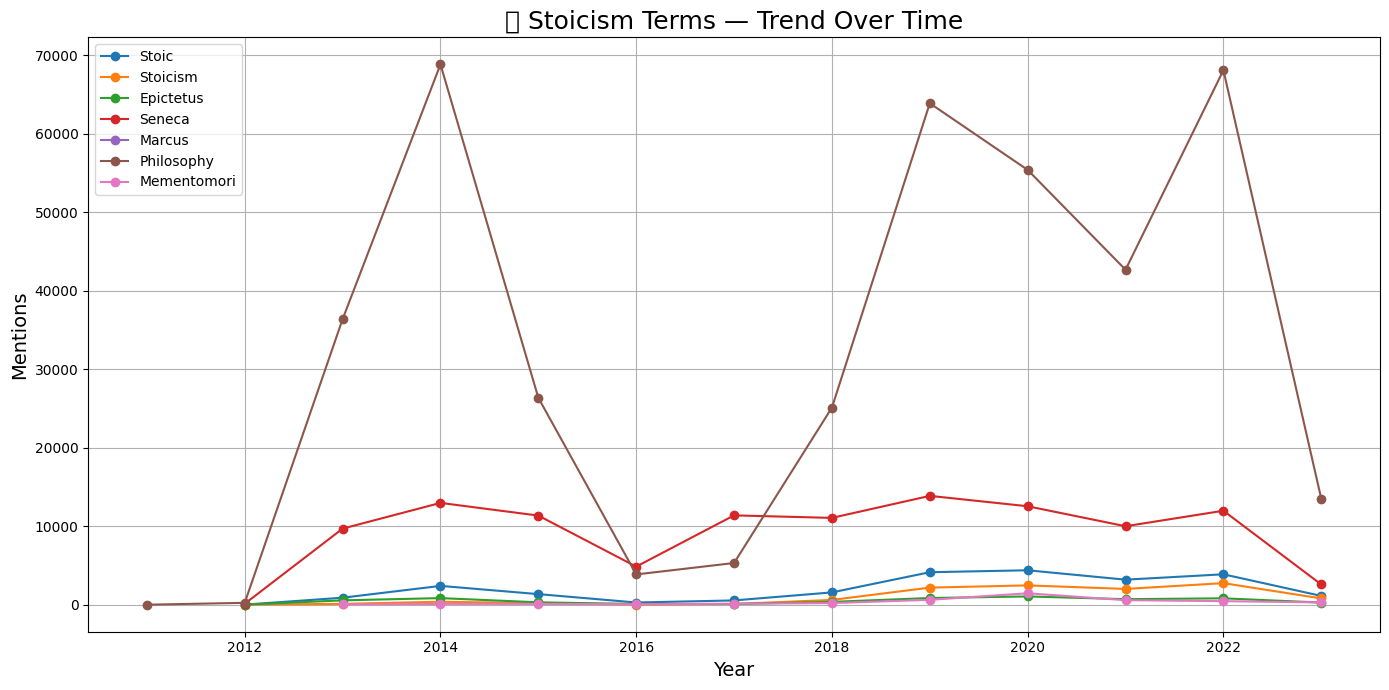

/tmp/ipykernel_501841/426203631.py:54: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


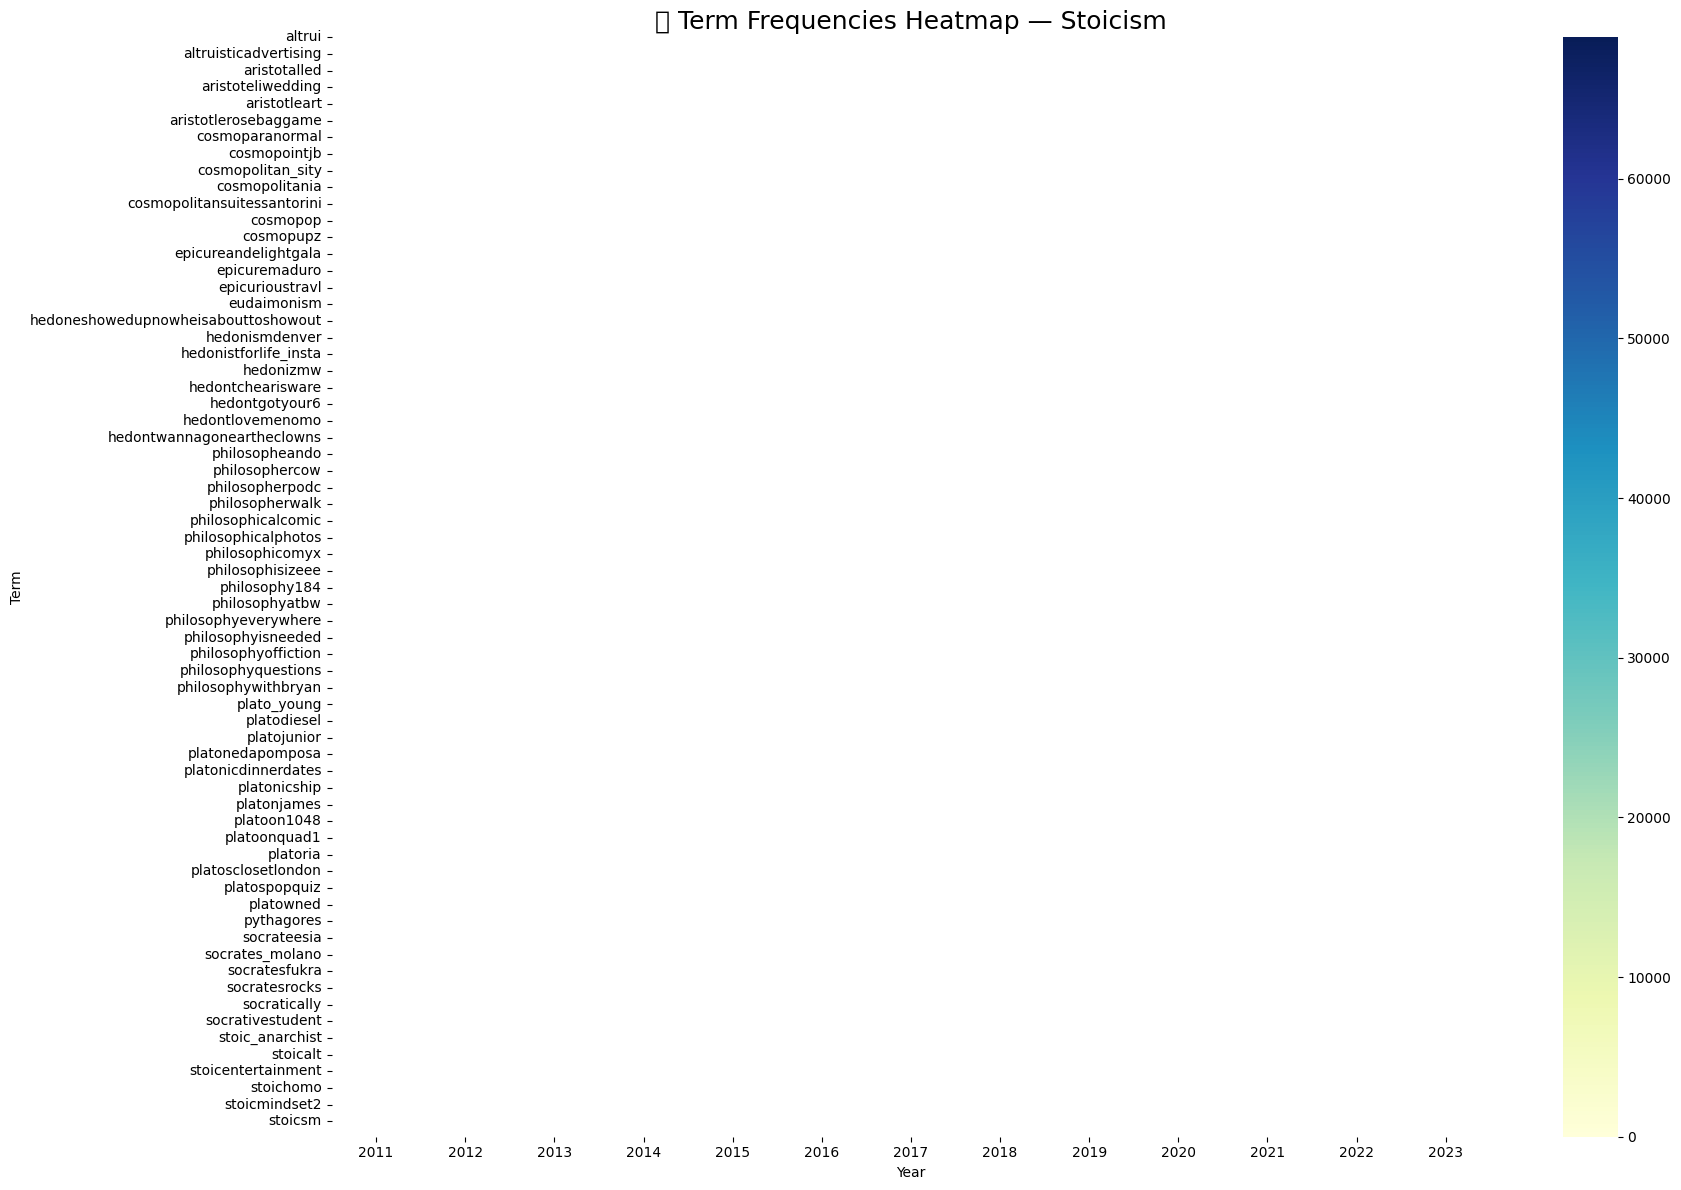


✅ Trend plots generated successfully!


In [ ]:
# 🚀 Block 7 — Visualization of Keyword Trends (Auto-run) — v6

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# -----------------------------
# CONFIGURATION
# -----------------------------
FREQ_FILE = os.path.join(OUTPUT_DIR, "keyword_frequencies_by_year.csv")
TOP_TERMS_TO_PLOT = [
    "stoic", "stoicism", "epictetus", "seneca", "marcus", "philosophy", "mementomori"
]
MIN_YEAR = 2010
MAX_YEAR = 2023

# -----------------------------
# FUNCTION
# -----------------------------
def plot_keyword_trends(freq_file):
    print("\n──────────────────────────────────── 📊 PLOTTING TRENDS ─────────────────────────────────────", flush=True)

    try:
        df = pd.read_csv(freq_file, dtype=str)
        df["year"] = df["year"].astype(int)
        df["count"] = df["count"].astype(int)

        # Filter years of interest
        df = df[(df["year"] >= MIN_YEAR) & (df["year"] <= MAX_YEAR)]

        # Create pivot for heatmap
        pivot_df = df.pivot_table(index="term", columns="year", values="count", fill_value=0)

        # 📈 Plot line chart for selected top terms
        plt.figure(figsize=(14, 7))
        for term in TOP_TERMS_TO_PLOT:
            subset = df[df["term"] == term.lower()]
            plt.plot(subset["year"], subset["count"], marker='o', label=term.capitalize())

        plt.title("📈 Stoicism Terms — Trend Over Time", fontsize=18)
        plt.xlabel("Year", fontsize=14)
        plt.ylabel("Mentions", fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 🔥 Plot full heatmap (optional)
        plt.figure(figsize=(18, 12))
        sns.heatmap(pivot_df, cmap="YlGnBu", linewidths=0.5, annot=False)
        plt.title("🔥 Term Frequencies Heatmap — Stoicism", fontsize=18)
        plt.xlabel("Year")
        plt.ylabel("Term")
        plt.tight_layout()
        plt.show()

        print("\n✅ Trend plots generated successfully!", flush=True)

    except Exception as e:
        print(f"⚠️ Error plotting trends: {e}", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
plot_keyword_trends(FREQ_FILE)

In [ ]:
##🚀 Block 8 — Spatial Heatmap of Stoicism Tweets (v6)

In [ ]:
# 🚀 Block 8 — Spatial Heatmap of Stoicism Tweets (Auto-run) — v6

import folium
from folium.plugins import HeatMap
import pandas as pd
import glob
import os

# -----------------------------
# CONFIGURATION
# -----------------------------
MAP_OUTPUT = os.path.join(OUTPUT_DIR, "stoicism_spatial_heatmap.html")

# -----------------------------
# FUNCTION
# -----------------------------
def generate_spatial_heatmap(output_folder):
    print("\n──────────────────────────────────── 🌎 GENERATING SPATIAL HEATMAP ─────────────────────────────────────", flush=True)

    coords = []

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))

    for file in files:
        try:
            df = pd.read_csv(file, compression="gzip", dtype=str)
            if "latitude" not in df.columns or "longitude" not in df.columns:
                print(f"⚠️ Skipping {file}: No latitude/longitude columns.", flush=True)
                continue

            df = df.dropna(subset=["latitude", "longitude"])
            df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
            df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
            df = df.dropna(subset=["latitude", "longitude"])

            coords.extend(df[["latitude", "longitude"]].values.tolist())
            print(f"📦 Loaded {len(df)} geolocated tweets from {os.path.basename(file)}", flush=True)

        except Exception as e:
            print(f"⚠️ Error reading {file}: {e}", flush=True)

    if not coords:
        print("\n⚠️ No coordinates found to plot.", flush=True)
        return

    # Center map on global average
    mean_lat = sum(c[0] for c in coords) / len(coords)
    mean_lon = sum(c[1] for c in coords) / len(coords)

    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=2, tiles="CartoDB positron")
    HeatMap(coords, radius=8, blur=6, min_opacity=0.5).add_to(m)

    m.save(MAP_OUTPUT)
    print(f"\n✅ Spatial heatmap saved to: {MAP_OUTPUT}", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
generate_spatial_heatmap(OUTPUT_DIR)


──────────────────────────────────── 🌎 GENERATING SPATIAL HEATMAP ─────────────────────────────────────
⚠️ Error reading /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v6/filtered_tweets_2010.csv.gz: No columns to parse from file
📦 Loaded 1 geolocated tweets from filtered_tweets_2011.csv.gz
📦 Loaded 1275 geolocated tweets from filtered_tweets_2012.csv.gz
📦 Loaded 154537 geolocated tweets from filtered_tweets_2013.csv.gz
📦 Loaded 301090 geolocated tweets from filtered_tweets_2014.csv.gz
📦 Loaded 147518 geolocated tweets from filtered_tweets_2015.csv.gz
📦 Loaded 41030 geolocated tweets from filtered_tweets_2016.csv.gz
📦 Loaded 54713 geolocated tweets from filtered_tweets_2017.csv.gz
📦 Loaded 115218 geolocated tweets from filtered_tweets_2018.csv.gz
📦 Loaded 235448 geolocated tweets from filtered_tweets_2019.csv.gz
📦 Loaded 206052 geolocated tweets from filtered_tweets_2020.csv.gz
📦 Loaded 153277 geolocated tweets from filtered_tweets_2021.csv.gz
📦 Loaded 214753 geolocated tweets from filt

In [ ]:
##🚀 Block 9 — Yearly Tweets Overview (v6)


──────────────────────────────────── 📊 PLOTTING YEARLY TWEET COUNTS ─────────────────────────────────────


/tmp/ipykernel_501841/3994637984.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


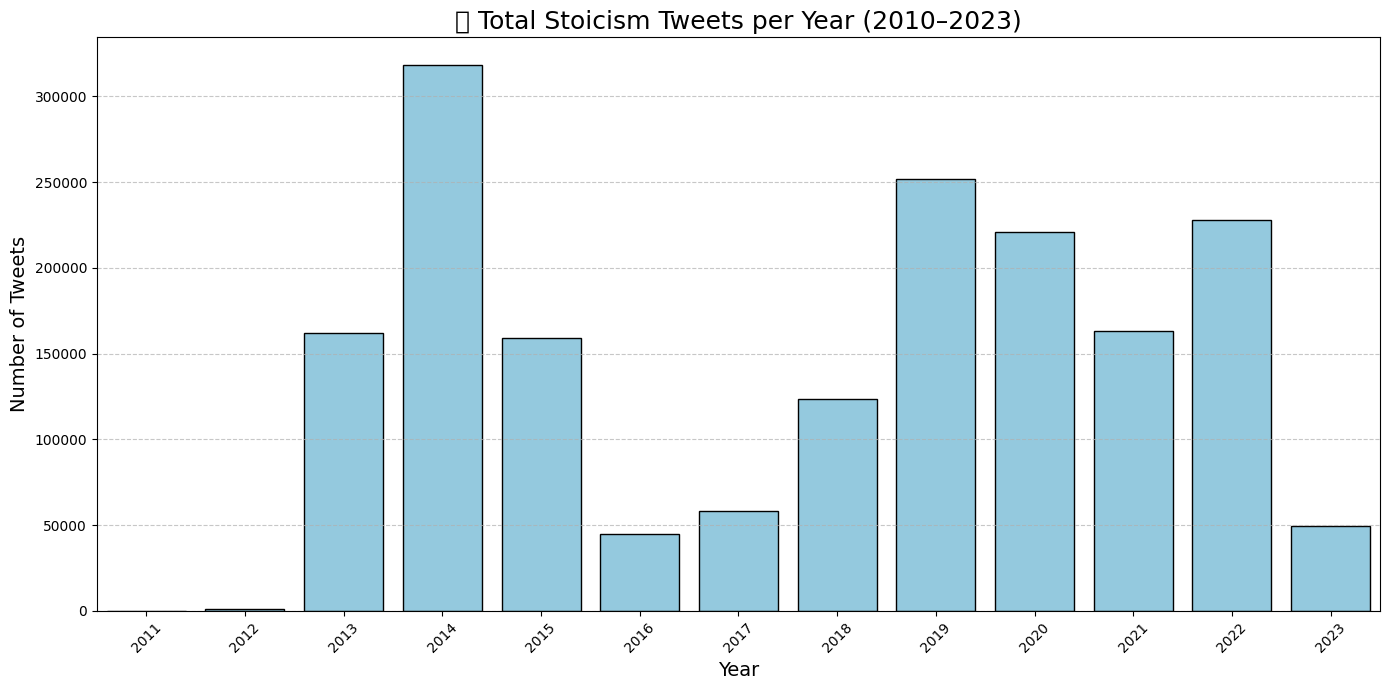

/tmp/ipykernel_501841/3994637984.py:49: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


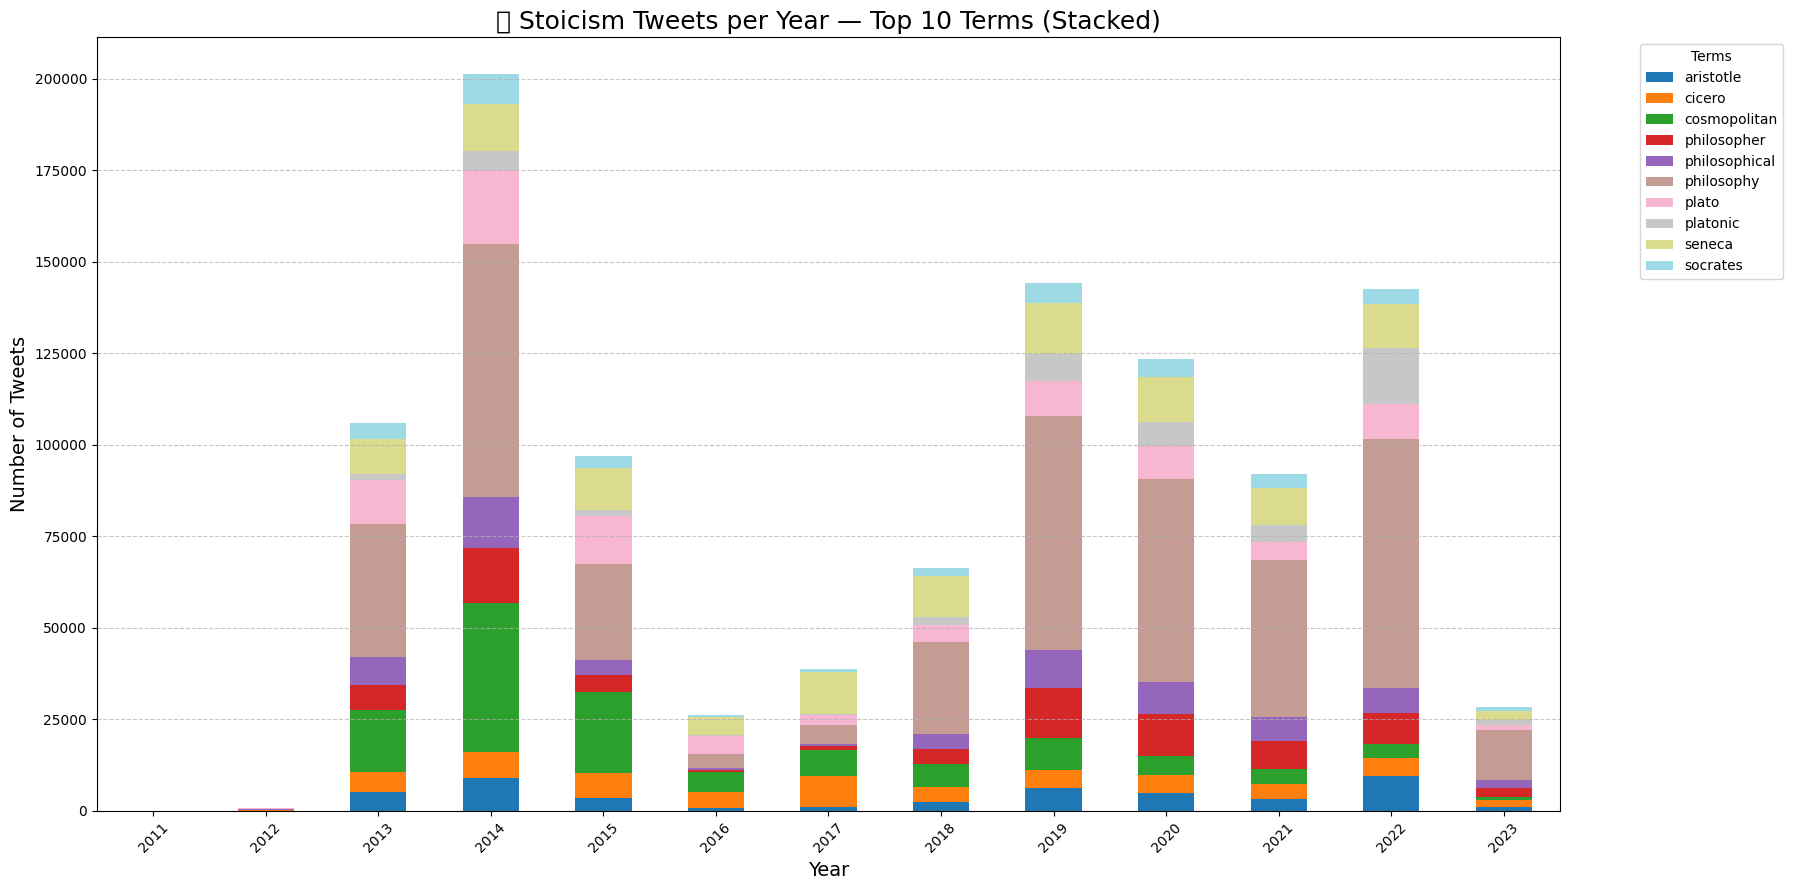


✅ Yearly tweet summary plots generated!


In [ ]:
# 🚀 Block 9 — Yearly Tweet Counts and Term Breakdown (Auto-run) — v6

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# CONFIGURATION
# -----------------------------
FREQ_FILE = os.path.join(OUTPUT_DIR, "keyword_frequencies_by_year.csv")

# -----------------------------
# FUNCTION
# -----------------------------
def plot_yearly_tweet_summary(freq_file):
    print("\n──────────────────────────────────── 📊 PLOTTING YEARLY TWEET COUNTS ─────────────────────────────────────", flush=True)

    try:
        df = pd.read_csv(freq_file, dtype=str)
        df["year"] = df["year"].astype(int)
        df["count"] = df["count"].astype(int)

        # 📈 1. Total tweets per year
        total_per_year = df.groupby("year")["count"].sum().reset_index()

        plt.figure(figsize=(14, 7))
        sns.barplot(x="year", y="count", data=total_per_year, color="skyblue", edgecolor="black")
        plt.title("📊 Total Stoicism Tweets per Year (2010–2023)", fontsize=18)
        plt.xlabel("Year", fontsize=14)
        plt.ylabel("Number of Tweets", fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(True, axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

        # 📊 2. Stacked barplot of top 10 terms
        top_terms = df.groupby("term")["count"].sum().nlargest(10).index.tolist()
        df_top = df[df["term"].isin(top_terms)]

        pivot_df = df_top.pivot_table(index="year", columns="term", values="count", fill_value=0)

        pivot_df.plot(kind="bar", stacked=True, figsize=(18, 9), colormap="tab20")
        plt.title("📊 Stoicism Tweets per Year — Top 10 Terms (Stacked)", fontsize=18)
        plt.xlabel("Year", fontsize=14)
        plt.ylabel("Number of Tweets", fontsize=14)
        plt.legend(title="Terms", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.grid(True, axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("\n✅ Yearly tweet summary plots generated!", flush=True)

    except Exception as e:
        print(f"⚠️ Error plotting yearly tweet summary: {e}", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
plot_yearly_tweet_summary(FREQ_FILE)

In [ ]:
##🚀 Block 10 — Geospatial Clustering with HDBSCAN (v6)

In [ ]:
# 🚀 Block 10 — Geospatial Clustering with HDBSCAN (Auto-run) — v6

import pandas as pd
import numpy as np
import glob
import os
import hdbscan
import folium
from folium.plugins import MarkerCluster

# -----------------------------
# CONFIGURATION
# -----------------------------
CLUSTER_OUTPUT = os.path.join(OUTPUT_DIR, "stoicism_cluster_map.html")
MIN_SAMPLES = 10
MIN_CLUSTER_SIZE = 30

# -----------------------------
# FUNCTION
# -----------------------------
def run_spatial_clustering(output_folder):
    print("\n──────────────────────────────────── 🧭 RUNNING GEOSPATIAL CLUSTERING ─────────────────────────────────────", flush=True)

    coords = []

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))

    for file in files:
        try:
            df = pd.read_csv(file, compression="gzip", dtype=str)
            if "latitude" not in df.columns or "longitude" not in df.columns:
                continue

            df = df.dropna(subset=["latitude", "longitude"])
            df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
            df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
            df = df.dropna(subset=["latitude", "longitude"])

            coords.extend(df[["latitude", "longitude"]].values.tolist())

        except Exception as e:
            print(f"⚠️ Error reading {file}: {e}", flush=True)

    if len(coords) < 100:
        print("⚠️ Not enough geolocated tweets for clustering.", flush=True)
        return

    # -----------------------------
    # HDBSCAN Clustering
    # -----------------------------
    coords_np = np.array(coords)
    coords_rad = np.radians(coords_np)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, min_samples=MIN_SAMPLES, metric='haversine')
    labels = clusterer.fit_predict(coords_rad)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"✅ Clustering complete — {n_clusters} clusters found", flush=True)

    # -----------------------------
    # Map Clusters
    # -----------------------------
    m = folium.Map(location=[0, 0], zoom_start=2, tiles="CartoDB positron")
    marker_cluster = MarkerCluster().add_to(m)

    for (lat, lon), label in zip(coords_np, labels):
        color = "gray" if label == -1 else f"#{hash(str(label)) & 0xFFFFFF:06x}"
        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.6,
            popup=f"Cluster {label}" if label != -1 else "Noise"
        ).add_to(marker_cluster)

    m.save(CLUSTER_OUTPUT)
    print(f"\n✅ Cluster map saved to: {CLUSTER_OUTPUT}", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
run_spatial_clustering(OUTPUT_DIR)


──────────────────────────────────── 🧭 RUNNING GEOSPATIAL CLUSTERING ─────────────────────────────────────
⚠️ Error reading /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v6/filtered_tweets_2010.csv.gz: No columns to parse from file
✅ Clustering complete — 10640 clusters found

✅ Cluster map saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v6/stoicism_cluster_map.html


In [ ]:
##🚀 Block 11 — Cluster Statistics Generator (v6)

In [ ]:
# 🚀 Block 11 — Cluster Statistics Generator (Auto-run) — v6

import pandas as pd
import numpy as np
import glob
import os
import hdbscan

# -----------------------------
# CONFIGURATION
# -----------------------------
CLUSTER_SUMMARY_OUTPUT = os.path.join(OUTPUT_DIR, "stoicism_cluster_summary.csv")
MIN_SAMPLES = 10
MIN_CLUSTER_SIZE = 30

# -----------------------------
# FUNCTION
# -----------------------------
def generate_cluster_statistics(output_folder):
    print("\n──────────────────────────────────── 📋 GENERATING CLUSTER STATISTICS ─────────────────────────────────────", flush=True)

    coords = []

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))

    for file in files:
        try:
            df = pd.read_csv(file, compression="gzip", dtype=str)
            if "latitude" not in df.columns or "longitude" not in df.columns:
                continue

            df = df.dropna(subset=["latitude", "longitude"])
            df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
            df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
            df = df.dropna(subset=["latitude", "longitude"])

            coords.extend(df[["latitude", "longitude"]].values.tolist())

        except Exception as e:
            print(f"⚠️ Error reading {file}: {e}", flush=True)

    if len(coords) < 100:
        print("⚠️ Not enough geolocated tweets for cluster stats.", flush=True)
        return

    # -----------------------------
    # Clustering
    # -----------------------------
    coords_np = np.array(coords)
    coords_rad = np.radians(coords_np)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, min_samples=MIN_SAMPLES, metric='haversine')
    labels = clusterer.fit_predict(coords_rad)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"✅ Clustering complete for stats — {n_clusters} clusters detected.", flush=True)

    # -----------------------------
    # Generate Summary
    # -----------------------------
    df_clusters = pd.DataFrame({
        "latitude": coords_np[:, 0],
        "longitude": coords_np[:, 1],
        "cluster": labels
    })

    df_clusters = df_clusters[df_clusters["cluster"] != -1]  # Exclude noise

    summary = df_clusters.groupby("cluster").agg(
        n_tweets=("cluster", "count"),
        centroid_latitude=("latitude", "mean"),
        centroid_longitude=("longitude", "mean")
    ).reset_index()

    summary = summary.sort_values(by="n_tweets", ascending=False)
    summary.to_csv(CLUSTER_SUMMARY_OUTPUT, index=False)

    print(f"\n✅ Cluster summary saved to: {CLUSTER_SUMMARY_OUTPUT}", flush=True)
    print(f"🔢 Total clusters in summary: {len(summary)}", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
generate_cluster_statistics(OUTPUT_DIR)


──────────────────────────────────── 📋 GENERATING CLUSTER STATISTICS ─────────────────────────────────────
⚠️ Error reading /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v6/filtered_tweets_2010.csv.gz: No columns to parse from file
✅ Clustering complete for stats — 10640 clusters detected.

✅ Cluster summary saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v6/stoicism_cluster_summary.csv
🔢 Total clusters in summary: 10640


In [ ]:
##🚀 Block 12 — Tweets by Country (Latitude and Longitude Based)

In [ ]:
# 🚀 Block 12 — Geolocation-Based Tweet Country Summary (Auto-run) — v6

import pandas as pd
import reverse_geocoder as rg
import pycountry
import os
import glob

# -----------------------------
# CONFIGURATION
# -----------------------------
COUNTRY_SUMMARY_OUTPUT = os.path.join(OUTPUT_DIR, "tweets_by_country.csv")
BATCH_SIZE = 10000

# -----------------------------
# FUNCTION
# -----------------------------
def generate_country_statistics(output_folder):
    print("\n──────────────────────────────────── 🌍 GENERATING TWEETS BY COUNTRY ─────────────────────────────────────", flush=True)

    coords = []

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))

    for file in files:
        try:
            df = pd.read_csv(file, compression="gzip", dtype=str)
            if "latitude" not in df.columns or "longitude" not in df.columns:
                continue

            df = df.dropna(subset=["latitude", "longitude"])
            df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
            df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
            df = df.dropna(subset=["latitude", "longitude"])

            coords.extend(df[["latitude", "longitude"]].values.tolist())

        except Exception as e:
            print(f"⚠️ Error reading {file}: {e}", flush=True)

    if not coords:
        print("⚠️ No coordinates found.", flush=True)
        return

    print(f"🔵 Total coordinates to process: {len(coords):,}", flush=True)

    # -----------------------------
    # Reverse Geocoding in Batches
    # -----------------------------
    results = []
    for i in range(0, len(coords), BATCH_SIZE):
        batch = coords[i:i + BATCH_SIZE]
        batch = [(float(lat), float(lon)) for lat, lon in batch]
        print(f"🌎 Geocoding batch {i // BATCH_SIZE + 1} ({len(batch)} points)...", flush=True)
        results.extend(rg.search(batch, mode=2))

    # Extract country codes
    country_codes = [result["cc"] for result in results]
    df_countries = pd.DataFrame(country_codes, columns=["country_code"])

    summary = df_countries.value_counts().reset_index()
    summary.columns = ["country_code", "n_tweets"]

    # Convert ISO2 to country names
    def get_country_name(code):
        try:
            return pycountry.countries.get(alpha_2=code).name
        except:
            return "Unknown"

    summary["country_name"] = summary["country_code"].apply(get_country_name)
    summary = summary[["country_name", "country_code", "n_tweets"]]
    summary = summary.sort_values(by="n_tweets", ascending=False)

    summary.to_csv(COUNTRY_SUMMARY_OUTPUT, index=False)

    print(f"\n✅ Country summary saved to: {COUNTRY_SUMMARY_OUTPUT}", flush=True)
    print(f"🔢 Total countries detected: {len(summary)}", flush=True)

    print("\n🏆 Top 10 countries by number of tweets:")
    print(summary.head(10).to_string(index=False))

# -----------------------------
# AUTO-RUN
# -----------------------------
generate_country_statistics(OUTPUT_DIR)


──────────────────────────────────── 🌍 GENERATING TWEETS BY COUNTRY ─────────────────────────────────────
⚠️ Error reading /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v6/filtered_tweets_2010.csv.gz: No columns to parse from file
🔵 Total coordinates to process: 1,670,629
🌎 Geocoding batch 1 (10000 points)...
Loading formatted geocoded file...
🌎 Geocoding batch 2 (10000 points)...
🌎 Geocoding batch 3 (10000 points)...
🌎 Geocoding batch 4 (10000 points)...
🌎 Geocoding batch 5 (10000 points)...
🌎 Geocoding batch 6 (10000 points)...
🌎 Geocoding batch 7 (10000 points)...
🌎 Geocoding batch 8 (10000 points)...
🌎 Geocoding batch 9 (10000 points)...
🌎 Geocoding batch 10 (10000 points)...
🌎 Geocoding batch 11 (10000 points)...
🌎 Geocoding batch 12 (10000 points)...
🌎 Geocoding batch 13 (10000 points)...
🌎 Geocoding batch 14 (10000 points)...
🌎 Geocoding batch 15 (10000 points)...
🌎 Geocoding batch 16 (10000 points)...
🌎 Geocoding batch 17 (10000 points)...
🌎 Geocoding batch 18 (10000 points)...